The notebook implements a multimodal fall-severity classification pipeline.
It first extracts spectral audio features and maps contextual attributes such as surface type and body position.
K-Means is then applied to fall samples to derive data-driven High and Low severity groups.
These severity labels are used to train a transformer-based audio model (AST) fused with a lightweight meta-MLP.
The fused architecture learns how environmental context influences acoustic patterns and predicts severity across High, Low, and No-Fall classes.

# SETUP & IMPORTS

In [40]:
!pip install --quiet librosa transformers torch torchvision torchaudio scikit-learn pandas matplotlib

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from transformers import ASTModel, ASTFeatureExtractor, AutoModel, AutoFeatureExtractor
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import f_oneway

# HuggingFace AST
from transformers import ASTModel, ASTFeatureExtractor

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


# LOAD .WAV FILES AND PARSE METADATA

In [66]:
DATA_DIR = "/kaggle/input/fall-audio-detection-dataset"

records = []

for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if not f.lower().endswith(".wav"):
            continue

        path = os.path.join(root, f)
        base = os.path.splitext(f)[0]    

        try:
            aa, bbb, cc, ddd, ff = base.split("-")
        except ValueError:
            print("Filename not matching pattern:", f)
            continue

        # Binary fall vs non-fall from FF code
        binary_label = "Fall" if ff == "01" else "No-Fall"

        records.append({
            "filename": f,
            "filepath": path,
            "AA": aa,
            "CC": cc,
            "FF": ff,
            "Binary_Label": binary_label,
        })

df = pd.DataFrame(records)
print("Total audio files:", len(df))
df.head()

Total audio files: 950


,filename,filepath,AA,CC,FF,Binary_Label
0,04-246-00-006-02.wav,/kaggle/input/fall-audio-detection-dataset/04-...,04,00,02,No-Fall
1,07-272-00-107-02.wav,/kaggle/input/fall-audio-detection-dataset/07-...,07,00,02,No-Fall
2,07-566-01-048-01.wav,/kaggle/input/fall-audio-detection-dataset/07-...,07,01,01,Fall
3,02-520-04-075-01.wav,/kaggle/input/fall-audio-detection-dataset/02-...,02,04,01,Fall
4,06-074-00-185-02.wav,/kaggle/input/fall-audio-detection-dataset/06-...,06,00,02,No-Fall


# CONTEXT MAPPING (CC -> location / surface / position)

In [67]:
# Map CC codes to semantic context
env_map = {
    "01": {"location": "Basement", "surface": "Carpet over concrete", "position": "Lying"},
    "02": {"location": "Basement", "surface": "Carpet over concrete", "position": "Standing"},
    "03": {"location": "Lab",      "surface": "Carpet over wood",      "position": "Lying"},
    "04": {"location": "Lab",      "surface": "Carpet over wood",      "position": "Standing"},
    "05": {"location": "Stairs",   "surface": "Concrete",              "position": "Lying"},
    "06": {"location": "Wood",     "surface": "Wood",                  "position": "Lying"},
    "07": {"location": "Wood",     "surface": "Wood",                  "position": "Standing"},
}

def get_env(cc, key):
    info = env_map.get(cc)
    if info is None:
        return "Unknown"
    return info.get(key, "Unknown")

# Add semantic context columns
df["location"] = df["CC"].map(lambda x: get_env(x, "location"))
df["surface"]  = df["CC"].map(lambda x: get_env(x, "surface"))
df["position"] = df["CC"].map(lambda x: get_env(x, "position"))

# Numerical encodings for meta branch (context features)
df["position_enc"] = df["position"].map({"Standing": 0, "Lying": 1}).fillna(-1).astype(int)
df["surface_enc"]  = df["surface"].astype("category").cat.codes

df.head()

,filename,filepath,AA,CC,FF,Binary_Label,location,surface,position,position_enc,surface_enc
0,04-246-00-006-02.wav,/kaggle/input/fall-audio-detection-dataset/04-...,04,00,02,No-Fall,Unknown,Unknown,Unknown,-1,3
1,07-272-00-107-02.wav,/kaggle/input/fall-audio-detection-dataset/07-...,07,00,02,No-Fall,Unknown,Unknown,Unknown,-1,3
2,07-566-01-048-01.wav,/kaggle/input/fall-audio-detection-dataset/07-...,07,01,01,Fall,Basement,Carpet over concrete,Lying,1,0
3,02-520-04-075-01.wav,/kaggle/input/fall-audio-detection-dataset/02-...,02,04,01,Fall,Lab,Carpet over wood,Standing,0,1
4,06-074-00-185-02.wav,/kaggle/input/fall-audio-detection-dataset/06-...,06,00,02,No-Fall,Unknown,Unknown,Unknown,-1,3


# HAND-CRAFTED AUDIO FEATURES + CLUSTERING

In [68]:
def compute_energy(y):
    return float(np.sum(y ** 2))

def compute_centroid(y, sr):
    return float(librosa.feature.spectral_centroid(y=y, sr=sr).mean())

def compute_bandwidth(y, sr):
    return float(librosa.feature.spectral_bandwidth(y=y, sr=sr).mean())

def compute_rolloff(y, sr):
    return float(librosa.feature.spectral_rolloff(y=y, sr=sr).mean())

def compute_flatness(y):
    return float(librosa.feature.spectral_flatness(y=y).mean())

def compute_flux(y):
    S = np.abs(librosa.stft(y))
    flux = librosa.onset.onset_strength(S=S)
    return float(np.mean(flux))

def compute_hf_ratio(y, sr):
    # Ratio of energy above 2 kHz
    S = np.abs(librosa.stft(y))
    freqs = librosa.fft_frequencies(sr=sr)
    hf_mask = freqs > 2000
    hf_energy = S[hf_mask].sum()
    total_energy = S.sum() + 1e-8
    return float(hf_energy / total_energy)


# Compute features for ALL samples
feature_rows = []
TARGET_SR = 16000   # temporary; AST will override later but OK for feature extraction

for i, row in tqdm(df.iterrows(), total=len(df)):
    y, sr = librosa.load(row["filepath"], sr=TARGET_SR)

    energy      = compute_energy(y)
    centroid    = compute_centroid(y, sr)
    bandwidth   = compute_bandwidth(y, sr)
    rolloff     = compute_rolloff(y, sr)
    flatness    = compute_flatness(y)
    flux        = compute_flux(y)
    hf_ratio    = compute_hf_ratio(y, sr)

    feature_rows.append({
        "filepath": row["filepath"],
        "energy": energy,
        "centroid": centroid,
        "bandwidth": bandwidth,
        "rolloff": rolloff,
        "flatness": flatness,
        "flux": flux,
        "hf_ratio": hf_ratio,

        # context encodings from Block 2
        "position_enc": row["position_enc"],
        "surface_enc": row["surface_enc"],

        # binary fall label from Block 1
        "Binary_Label": row["Binary_Label"],
    })

feature_df = pd.DataFrame(feature_rows)
feature_df.head()

100%|██████████| 950/950 [00:24<00:00, 39.35it/s]


,filepath,energy,centroid,bandwidth,rolloff,flatness,flux,hf_ratio,position_enc,surface_enc,Binary_Label
0,/kaggle/input/fall-audio-detection-dataset/04-...,1.643398,2233.891662,1990.200330,4639.128989,0.070092,0.018496,0.482795,-1,3,No-Fall
1,/kaggle/input/fall-audio-detection-dataset/07-...,343.628784,2221.527509,2081.470254,4755.734707,0.064578,0.123733,0.412231,-1,3,No-Fall
2,/kaggle/input/fall-audio-detection-dataset/07-...,148.246490,1682.287277,1912.760307,3651.263298,0.041656,0.092588,0.342390,1,0,Fall
3,/kaggle/input/fall-audio-detection-dataset/02-...,245.104660,2144.657828,2065.466642,4428.440824,0.072928,0.099502,0.341962,0,1,Fall
4,/kaggle/input/fall-audio-detection-dataset/06-...,21.017859,2174.322652,2121.728671,4762.217420,0.050504,0.058184,0.385692,-1,3,No-Fall


In [ ]:
full_df = feature_df.merge(df[["filepath", "label"]], on="filepath", how="left")

print("Columns in full_df:", full_df.columns)

feature_cols = [
    "energy",
    "hf_ratio",
    "centroid",
    "bandwidth",
    "rolloff",
    "flatness",
    "flux",
    "position_enc",
    "surface_enc",
]

label_col = "label"

print("=== ANOVA results for High vs Low vs No-Fall ===\n")

for feat in feature_cols:
    if feat not in full_df.columns:
        print(f"Feature {feat} not found in full_df → skipping.\n")
        continue

    high_vals = full_df[full_df[label_col] == "High"][feat].values
    low_vals  = full_df[full_df[label_col] == "Low"][feat].values
    no_vals   = full_df[full_df[label_col] == "No-Fall"][feat].values

    
    if len(high_vals) == 0 or len(low_vals) == 0 or len(no_vals) == 0:
        print(f"Feature {feat}: one of the groups is empty → skipping.\n")
        continue

    F, p = f_oneway(high_vals, low_vals, no_vals)

    print(f"Feature: {feat}")
    print(f"  F-statistic = {F:.4f}")
    print(f"  p-value     = {p:.8f}")

    if p < 0.05:
        print("  → Significant difference ✔ (good)\n")
    else:
        print("  → NOT significant ✖ (classes overlap)\n")


Columns in full_df: Index(['filepath', 'energy', 'centroid', 'bandwidth', 'rolloff', 'flatness',
       'flux', 'hf_ratio', 'position_enc', 'surface_enc', 'Binary_Label',
       'label'],
      dtype='object')
=== ANOVA results for High vs Low vs No-Fall ===

Feature: energy
  F-statistic = 510.4076
  p-value     = 0.00000000
  → Significant difference ✔ (good)

Feature: hf_ratio
  F-statistic = 292.1388
  p-value     = 0.00000000
  → Significant difference ✔ (good)

Feature: centroid
  F-statistic = 242.4307
  p-value     = 0.00000000
  → Significant difference ✔ (good)

Feature: bandwidth
  F-statistic = 196.4083
  p-value     = 0.00000000
  → Significant difference ✔ (good)

Feature: rolloff
  F-statistic = 260.0143
  p-value     = 0.00000000
  → Significant difference ✔ (good)

Feature: flatness
  F-statistic = 132.8566
  p-value     = 0.00000000
  → Significant difference ✔ (good)

Feature: flux
  F-statistic = 172.2606
  p-value     = 0.00000000
  → Significant difference ✔ (good

# KMEANS CLUSTERING FOR RISK (FALLS ONLY)

In [69]:
falls = feature_df[feature_df["Binary_Label"] == "Fall"].copy()

feature_cols = [
    "position_enc",
    "surface_enc",
    "energy",
    "hf_ratio",
    "centroid",
    "bandwidth",
    "rolloff",
    "flatness",
    "flux"
]

X_falls = falls[feature_cols].values


In [70]:
kmeans = KMeans(
    n_clusters=2,
    random_state=42,
    n_init=10
)

falls["kmeans_cluster"] = kmeans.fit_predict(X_falls)


In [71]:
cluster_means = falls.groupby("kmeans_cluster")["energy"].mean()
high_cluster = cluster_means.idxmax()   

falls["risk_label"] = falls["kmeans_cluster"].apply(
    lambda c: "High" if c == high_cluster else "Low"
)

In [72]:

sil_score = silhouette_score(X_falls, falls["kmeans_cluster"])
print("Silhouette score (KMeans, falls only):", sil_score)


Silhouette score (KMeans, falls only): 0.5200801180300921


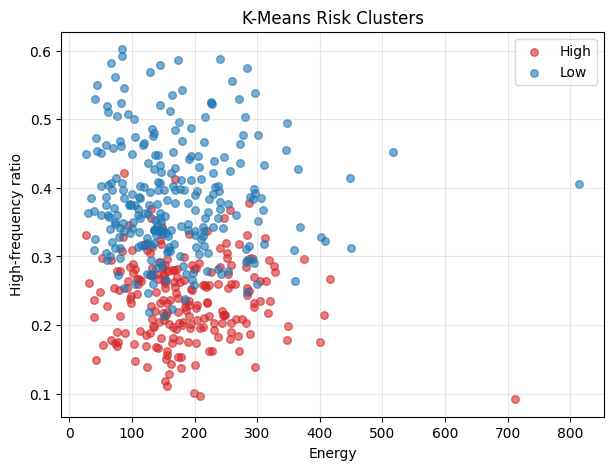

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

for label, color in zip(["High", "Low"], ["tab:red", "tab:blue"]):
    subset = falls[falls["risk_label"] == label]

    plt.scatter(
        subset["energy"],
        subset["hf_ratio"],
        alpha=0.6,
        s=30,
        c=color,
        label=label
    )

plt.xlabel("Energy")
plt.ylabel("High-frequency ratio")
plt.title("K-Means Risk Clusters")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# FINAL LABEL MERGING (High / Low / No-Fall)

In [38]:
# Map risk labels only for fall samples
risk_map = dict(zip(falls["filepath"], falls["risk_label"]))

final_labels = []
for i, row in df.iterrows():
    if row["Binary_Label"] == "No-Fall":
        final_labels.append("No-Fall")
    else:
        final_labels.append(risk_map[row["filepath"]])

df["label"] = final_labels
df.head()

,filename,filepath,AA,CC,FF,Binary_Label,location,surface,position,position_enc,surface_enc,label
0,04-246-00-006-02.wav,/kaggle/input/fall-audio-detection-dataset/04-...,04,00,02,No-Fall,Unknown,Unknown,Unknown,-1,3,No-Fall
1,07-272-00-107-02.wav,/kaggle/input/fall-audio-detection-dataset/07-...,07,00,02,No-Fall,Unknown,Unknown,Unknown,-1,3,No-Fall
2,07-566-01-048-01.wav,/kaggle/input/fall-audio-detection-dataset/07-...,07,01,01,Fall,Basement,Carpet over concrete,Lying,1,0,High
3,02-520-04-075-01.wav,/kaggle/input/fall-audio-detection-dataset/02-...,02,04,01,Fall,Lab,Carpet over wood,Standing,0,1,Low
4,06-074-00-185-02.wav,/kaggle/input/fall-audio-detection-dataset/06-...,06,00,02,No-Fall,Unknown,Unknown,Unknown,-1,3,No-Fall


In [75]:
falls = feature_df[feature_df["Binary_Label"] == "Fall"].copy()

feature_cols = [
    "position_enc",
    "surface_enc",
    "energy",
    "hf_ratio",
    "centroid",
    "bandwidth",
    "rolloff",
    "flatness",
    "flux",
]

X_falls = falls[feature_cols].values

kmeans = KMeans(
    n_clusters=2,
    random_state=42,
    n_init=10
)

falls["kmeans_cluster"] = kmeans.fit_predict(X_falls)

cluster_means = falls.groupby("kmeans_cluster")["energy"].mean()
high_cluster = cluster_means.idxmax()  

falls["risk_label"] = falls["kmeans_cluster"].apply(
    lambda c: "High" if c == high_cluster else "Low"
)

print(cluster_means)
print("High cluster index:", high_cluster)

sil_kmeans = silhouette_score(X_falls, falls["kmeans_cluster"])
print("Silhouette score (KMeans, falls only):", sil_kmeans)

risk_map = dict(zip(falls["filepath"], falls["risk_label"]))

final_labels = []
for _, row in df.iterrows():
    if row["Binary_Label"] == "No-Fall":
        final_labels.append("No-Fall")
    else:
        final_labels.append(risk_map.get(row["filepath"], "Low"))

df["label"] = final_labels

df["label"].value_counts()


kmeans_cluster
0    184.765117
1    169.377013
Name: energy, dtype: float64
High cluster index: 0
Silhouette score (KMeans, falls only): 0.5200801180300921


label
No-Fall    475
Low        256
High       219
Name: count, dtype: int64

High example file: 04-085-01-050-01.wav
Low example file: 09-265-04-092-01.wav
No-Fall example file: 03-501-00-268-02.wav


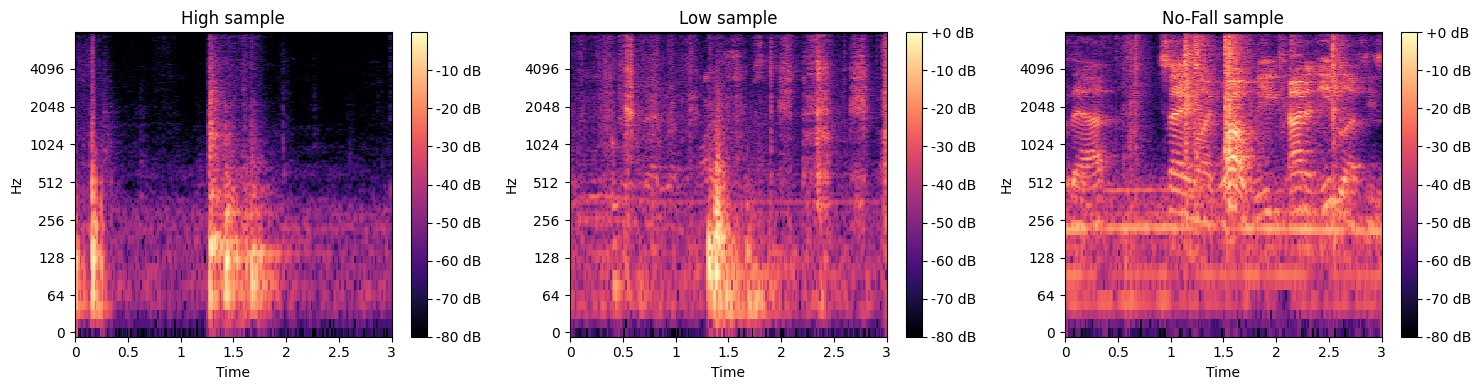

In [76]:
labels_to_show = ["High", "Low", "No-Fall"]

plt.figure(figsize=(15, 4))

for i, lab in enumerate(labels_to_show, start=1):
    subset = df[df["label"] == lab]

    if subset.empty:
        print(f"No samples found for label: {lab}")
        continue

    sample_row = subset.sample(1, random_state=0)
    file_path = sample_row["filepath"].iloc[0]

    print(f"{lab} example file:", sample_row["filename"].iloc[0])

    try:
        y, sr = librosa.load(file_path, sr=TARGET_SR)
    except NameError:
        y, sr = librosa.load(file_path, sr=16000)

    # STFT
    n_fft = 1024
    hop_length = 256
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    plt.subplot(1, 3, i)
    librosa.display.specshow(
        S_db,
        sr=sr,
        hop_length=hop_length,
        x_axis="time",
        y_axis="log",
    )
    plt.title(f"{lab} sample", fontsize=12)
    plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()


In [78]:
# Block 5 — split using folds AA (01-09 train, 10 val)

train_folds = ["01", "02", "03", "04", "05", "06", "07", "08"]
val_folds   = ["09","10"]

df_train = df[df["AA"].isin(train_folds)].reset_index(drop=True)
df_val   = df[df["AA"].isin(val_folds)].reset_index(drop=True)

print("Train label counts:")
print(df_train["label"].value_counts(), "\n")

print("Val label counts:")
print(df_val["label"].value_counts(), "\n")


Train label counts:
label
No-Fall    376
Low        205
High       179
Name: count, dtype: int64 

Val label counts:
label
No-Fall    99
Low        51
High       40
Name: count, dtype: int64 



# LOAD AST MODEL FROM KAGGLE INPUT (NO ZIP)

In [79]:
AST_DIR = "/kaggle/input/ast-fall/ast_fall_detector"

print("Looking for model files in:", AST_DIR)
!ls -R $AST_DIR

# loading using AST classes
try:
    feature_extractor = ASTFeatureExtractor.from_pretrained(AST_DIR)
    ast_backbone = ASTModel.from_pretrained(AST_DIR)
    print("Loaded using ASTModel / ASTFeatureExtractor")
except Exception as e:
    print("ASTModel/ASTFeatureExtractor failed:", e)
    print("Falling back to AutoModel/AutoFeatureExtractor...")
    feature_extractor = AutoFeatureExtractor.from_pretrained(AST_DIR)
    ast_backbone = AutoModel.from_pretrained(AST_DIR)

# Use AST sampling rate
TARGET_SR = feature_extractor.sampling_rate
print("Sampling rate:", TARGET_SR)

# Move model to device
ast_backbone.to(DEVICE)
print("Model loaded on:", DEVICE)

Looking for model files in: /kaggle/input/ast-fall/ast_fall_detector
/kaggle/input/ast-fall/ast_fall_detector:
config.json  model.safetensors	preprocessor_config.json
Loaded using ASTModel / ASTFeatureExtractor
Sampling rate: 16000
Model loaded on: cuda


# DATASET + COLLATE FOR AST + CONTEXT META FEATURES

In [80]:
class FallASTDataset(Dataset):
    """
    Returns:
        waveform: 1D float tensor
        meta: tensor([position_enc, surface_enc])
        label_idx: integer (0=High, 1=Low, 2=No-Fall)
    """
    def __init__(self, df_split):
        self.df = df_split.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load raw waveform at AST sampling rate
        y, _ = librosa.load(row["filepath"], sr=TARGET_SR)
        y = torch.tensor(y, dtype=torch.float32)

        # Meta features
        meta = torch.tensor(
            [row["position_enc"], row["surface_enc"]],
            dtype=torch.float32
        )

        # Label index
        label_map = {"High": 0, "Low": 1, "No-Fall": 2}
        label_idx = label_map[row["label"]]

        return y, meta, label_idx


def ast_collate(batch):
    """
    Input:  list of (waveform, meta, label_idx)
    Output: ast_inputs (dict), meta tensor, labels tensor
    """
    waves, metas, labels = zip(*batch)

    wave_list = [w.numpy() for w in waves]

    ast_inputs = feature_extractor(
        wave_list,
        sampling_rate=TARGET_SR,
        return_tensors="pt",
        padding=True,
        truncation=True
    )

    metas = torch.stack(metas, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)

    return ast_inputs, metas, labels


# Build datasets and dataloaders using the NEW class name
train_ds = FallASTDataset(df_train)
val_ds   = FallASTDataset(df_val)

BATCH_SIZE = 8

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,
                      shuffle=True, collate_fn=ast_collate)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE,
                      shuffle=False, collate_fn=ast_collate)

print("Dataloaders ready:",
      len(train_dl), "train batches,",
      len(val_dl), "val batches,")


Dataloaders ready: 95 train batches, 24 val batches,


# BLOCK 8 — AST + META MODEL DEFINITION

In [81]:
class ASTWithMeta(nn.Module):
    """
    - Audio branch: AST backbone → pooled embedding
    - Meta branch: position_enc + surface_enc → small MLP
    - Fusion: concat(audio_emb, meta_emb) → classifier (3 classes)
    """
    def __init__(self, ast_backbone, num_classes=3, meta_dim=2, freeze_backbone=False):
        super().__init__()

        self.ast = ast_backbone

        if freeze_backbone:
            for p in self.ast.parameters():
                p.requires_grad = False

        hidden_dim = self.ast.config.hidden_size

        self.meta_mlp = nn.Sequential(
            nn.Linear(meta_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.classifier = nn.Linear(hidden_dim + 16, num_classes)

    def forward(self, ast_inputs, meta):
        """
        ast_inputs: dict from feature_extractor (input_values, attention_mask, etc.)
        meta: tensor (B, meta_dim)
        """
        outputs = self.ast(**ast_inputs)

        # Some AST implementations have pooler_output, some don't
        if getattr(outputs, "pooler_output", None) is not None:
            audio_feats = outputs.pooler_output  # (B, hidden_dim)
        else:
            audio_feats = outputs.last_hidden_state.mean(dim=1)  # (B, hidden_dim)

        meta_feats = self.meta_mlp(meta)  # (B, 16)

        fused = torch.cat([audio_feats, meta_feats], dim=1)  # (B, hidden_dim+16)
        logits = self.classifier(fused)                      # (B, num_classes)

        return logits


# Instantiate model, loss, optimizer
model = ASTWithMeta(ast_backbone, num_classes=3, meta_dim=2,
                    freeze_backbone=False).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

print("Model ready on", DEVICE)


Model ready on cuda


# BLOCK 9 — TRAINING + VALIDATION LOOP (AST + META)

In [82]:
EPOCHS = 15
best_val_acc = 0.0

train_hist = []
val_hist = []

for epoch in range(1, EPOCHS + 1):

    # TRAIN
    model.train()
    total = 0
    correct = 0
    running_loss = 0.0

    for ast_inputs, meta, labels in train_dl:
        ast_inputs = {k: v.to(DEVICE) for k, v in ast_inputs.items()}
        meta = meta.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        logits = model(ast_inputs, meta)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_hist.append(train_acc)

    # VALIDATE
    model.eval()
    v_total = 0
    v_correct = 0
    v_running_loss = 0.0

    with torch.no_grad():
        for ast_inputs, meta, labels in val_dl:
            ast_inputs = {k: v.to(DEVICE) for k, v in ast_inputs.items()}
            meta = meta.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(ast_inputs, meta)
            loss = criterion(logits, labels)

            v_running_loss += loss.item() * labels.size(0)

            preds = logits.argmax(dim=1)
            v_correct += (preds == labels).sum().item()
            v_total += labels.size(0)

    val_loss = v_running_loss / v_total
    val_acc = v_correct / v_total
    val_hist.append(val_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} train_acc={train_acc:.3f} | "
        f"val_loss={val_loss:.4f} val_acc={val_acc:.3f}"
    )

    # Save best model by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_ast_meta.pth")

print("Best validation accuracy:", best_val_acc)

Epoch 02 | train_loss=0.3123 train_acc=0.863 | val_loss=0.2118 val_acc=0.916
Epoch 03 | train_loss=0.2082 train_acc=0.907 | val_loss=0.3127 val_acc=0.916
Epoch 04 | train_loss=0.1918 train_acc=0.939 | val_loss=0.2318 val_acc=0.905
Epoch 05 | train_loss=0.1217 train_acc=0.951 | val_loss=0.1551 val_acc=0.942
Epoch 06 | train_loss=0.1023 train_acc=0.958 | val_loss=0.2428 val_acc=0.905
Epoch 07 | train_loss=0.0334 train_acc=0.991 | val_loss=0.1698 val_acc=0.937
Epoch 08 | train_loss=0.0207 train_acc=0.996 | val_loss=0.3015 val_acc=0.932
Epoch 09 | train_loss=0.0885 train_acc=0.975 | val_loss=0.2132 val_acc=0.926
Epoch 10 | train_loss=0.0582 train_acc=0.980 | val_loss=0.7234 val_acc=0.889
Epoch 11 | train_loss=0.0588 train_acc=0.980 | val_loss=0.1497 val_acc=0.963
Epoch 12 | train_loss=0.0039 train_acc=0.999 | val_loss=0.1927 val_acc=0.947
Epoch 14 | train_loss=0.0866 train_acc=0.966 | val_loss=0.2694 val_acc=0.916
Epoch 15 | train_loss=0.0528 train_acc=0.980 | val_loss=0.3007 val_acc=0.911

# BLOCK 10 — EVALUATION ON HELD-OUT TEST FOLD (10)

In [83]:
# Reload best model (based on validation accuracy)
model.load_state_dict(torch.load("best_ast_meta.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for ast_inputs, meta, labels in val_dl:
        ast_inputs = {k: v.to(DEVICE) for k, v in ast_inputs.items()}
        meta = meta.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(ast_inputs, meta)
        preds = logits.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

# Map indices back to class names
idx_to_class = {0: "High", 1: "Low", 2: "No-Fall"}

print("Classification Report (Fold 10):")
print(classification_report(
    all_labels,
    all_preds,
    target_names=[idx_to_class[i] for i in range(3)]
))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

Classification Report (Fold 10):
              precision    recall  f1-score   support

        High       0.93      0.93      0.93        40
         Low       0.94      0.92      0.93        51
     No-Fall       0.99      1.00      0.99        99

    accuracy                           0.96       190
   macro avg       0.95      0.95      0.95       190
weighted avg       0.96      0.96      0.96       190

Confusion Matrix (rows=true, cols=pred):
[[37  3  0]
 [ 3 47  1]
 [ 0  0 99]]


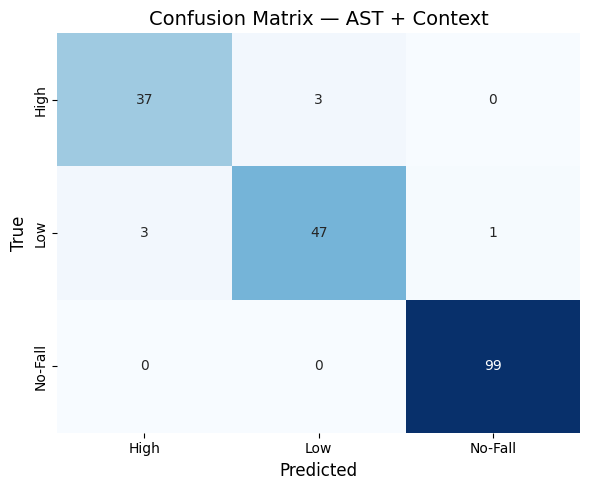

In [84]:
# Compute CM
cm = confusion_matrix(all_labels, all_preds)
classes = ["High", "Low", "No-Fall"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=classes,
            yticklabels=classes,
            cbar=False)

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix — AST + Context", fontsize=14)
plt.tight_layout()
plt.show()